In [1]:
import os
import sys
import torch 
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('high')

import mlflow.pytorch

import pytorch_lightning as pl
from lightning.pytorch.loggers import MLFlowLogger

In [2]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [25]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 1
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 30
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [26]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # # cal roll mean
    # regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    # regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    regions_df[region] = (regions_df[region]-regions_df[region].min())/(regions_df[region].max()-regions_df[region].min())
    
    # add week info
    regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [27]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W,week,month
date,,,,,,,,,,,,,,,,,
2013-03-01,0.003609,0.005575,0.092558,0.094169,0.036516,0.383910,0.349387,0.743897,0.233279,0.0,0.533383,1.000000,0.000000,0.291667,0.416667,9,3
2013-03-02,0.050207,0.063802,0.276890,0.357742,0.089874,0.218745,0.333100,0.743408,0.280681,0.0,0.217359,0.625000,0.208333,0.583333,0.375000,9,3
2013-03-03,0.141266,0.209601,0.459372,0.443441,0.197157,0.167320,0.437128,0.503551,0.341796,0.0,0.249258,0.833333,0.083333,0.458333,0.375000,9,3
2013-03-04,0.034346,0.068448,0.176210,0.237422,0.058877,0.334905,0.529510,0.563148,0.352486,0.0,0.382047,0.500000,0.500000,0.208333,0.416667,10,3
2013-03-05,0.283197,0.327139,0.700420,0.753352,0.296570,0.406093,0.452364,0.430892,0.422674,0.0,0.155045,0.833333,0.166667,0.708333,0.125000,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,0.032044,0.046225,0.128623,0.311156,0.056178,0.320586,0.428722,0.629031,0.361629,0.0,0.238131,0.791667,0.083333,0.333333,0.625000,8,2
2017-02-25,0.011663,0.022222,0.055877,0.218482,0.035392,0.393590,0.472417,0.585925,0.368169,0.0,0.278932,0.750000,0.166667,0.083333,0.833333,8,2
2017-02-26,0.045029,0.061247,0.080537,0.350020,0.075841,0.310100,0.471629,0.615805,0.410296,0.0,0.232938,0.541667,0.416667,0.500000,0.416667,8,2


In [28]:
import copy
feature = "PM2.5"
feature_df = regions_df[Region.DINGLING][[feature]]
window = PAST_WINDOW+FUTURE_WINDOW
shift = window
dfs = []
for i in range(shift):
    dfs.append((feature_df[feature].shift(i+1)))

feature_df = pd.concat(dfs, axis=1).dropna()

feature_df.columns=[f"shift_{shift-index-1}" for index in range(shift)]
feature_df

,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
date,,,,,,,,
2013-03-09,0.343351,0.331903,0.523204,0.245039,0.033353,0.096718,0.073119,0.006440
2013-03-10,0.135280,0.343351,0.331903,0.523204,0.245039,0.033353,0.096718,0.073119
2013-03-11,0.053236,0.135280,0.343351,0.331903,0.523204,0.245039,0.033353,0.096718
2013-03-12,0.274764,0.053236,0.135280,0.343351,0.331903,0.523204,0.245039,0.033353
2013-03-13,0.323869,0.274764,0.053236,0.135280,0.343351,0.331903,0.523204,0.245039
...,...,...,...,...,...,...,...,...
2017-02-24,0.020700,0.168218,0.156992,0.023052,0.185490,0.156770,0.032550,0.189507
2017-02-25,0.021604,0.020700,0.168218,0.156992,0.023052,0.185490,0.156770,0.032550
2017-02-26,0.022708,0.021604,0.020700,0.168218,0.156992,0.023052,0.185490,0.156770


In [29]:
feature_df.corr().style.background_gradient(cmap='coolwarm')

,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
shift_7,1.000000,0.543806,0.180123,0.051875,0.023309,0.043735,0.041740,0.010306
shift_6,0.543806,1.000000,0.544438,0.180451,0.051067,0.022869,0.043294,0.040910
shift_5,0.180123,0.544438,1.000000,0.544120,0.178385,0.049980,0.021987,0.041569
shift_4,0.051875,0.180451,0.544120,1.000000,0.543362,0.177778,0.049826,0.021591
shift_3,0.023309,0.051067,0.178385,0.543362,1.000000,0.543183,0.178119,0.050355
shift_2,0.043735,0.022869,0.049980,0.177778,0.543183,1.000000,0.543449,0.178364
shift_1,0.041740,0.043294,0.021987,0.049826,0.178119,0.543449,1.000000,0.543568
shift_0,0.010306,0.040910,0.041569,0.021591,0.050355,0.178364,0.543568,1.000000


In [35]:
feature = "PM2.5"
x_df = regions_df[Region.AOTIZHONGXIN][MODEL_INPUT_FEATURES].shift(FUTURE_WINDOW)
y_df = regions_df[Region.AOTIZHONGXIN][[feature]]
dataset_df = pd.concat([y_df,x_df],axis=1).dropna()
dataset_df.columns = ['target'] + MODEL_INPUT_FEATURES
print(dataset_df.head())
dataset_df.corr().style.background_gradient(cmap='coolwarm')

              target     PM2.5      PM10       SO2       NO2        CO   
date                                                                     
2013-03-02  0.050207  0.003609  0.005575  0.092558  0.094169  0.036516  \
2013-03-03  0.141266  0.050207  0.063802  0.276890  0.357742  0.089874   
2013-03-04  0.034346  0.141266  0.209601  0.459372  0.443441  0.197157   
2013-03-05  0.283197  0.034346  0.068448  0.176210  0.237422  0.058877   
2013-03-06  0.429894  0.283197  0.327139  0.700420  0.753352  0.296570   

                  O3      TEMP      PRES      DEWP  RAIN      WSPM  
date                                                                
2013-03-02  0.383910  0.349387  0.743897  0.233279   0.0  0.533383  
2013-03-03  0.218745  0.333100  0.743408  0.280681   0.0  0.217359  
2013-03-04  0.167320  0.437128  0.503551  0.341796   0.0  0.249258  
2013-03-05  0.334905  0.529510  0.563148  0.352486   0.0  0.382047  
2013-03-06  0.406093  0.452364  0.430892  0.422674   0.0  0.155045 

,target,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
target,1.000000,0.549336,0.509378,0.344272,0.559331,0.496330,-0.169221,-0.170202,0.131498,-0.018363,-0.092853,-0.377072
PM2.5,0.549336,1.000000,0.914227,0.495198,0.761035,0.821743,-0.208402,-0.142088,0.020490,0.091526,-0.029483,-0.395888
PM10,0.509378,0.914227,1.000000,0.519510,0.742784,0.733011,-0.186406,-0.127769,-0.016107,0.027383,-0.077217,-0.291933
SO2,0.344272,0.495198,0.519510,1.000000,0.512700,0.567316,-0.362488,-0.451468,0.264204,-0.359556,-0.116381,-0.170180
NO2,0.559331,0.761035,0.742784,0.512700,1.000000,0.771521,-0.459260,-0.225640,0.118474,0.012045,-0.090576,-0.592379
CO,0.496330,0.821743,0.733011,0.567316,0.771521,1.000000,-0.440110,-0.417289,0.275060,-0.170184,-0.046201,-0.360117
O3,-0.169221,-0.208402,-0.186406,-0.362488,-0.459260,-0.440110,1.000000,0.692559,-0.583774,0.499604,0.061315,0.232472
TEMP,-0.170202,-0.142088,-0.127769,-0.451468,-0.225640,-0.417289,0.692559,1.000000,-0.866124,0.903442,0.135152,-0.160110
PRES,0.131498,0.020490,-0.016107,0.264204,0.118474,0.275060,-0.583774,-0.866124,1.000000,-0.798438,-0.159926,0.149600
DEWP,-0.018363,0.091526,0.027383,-0.359556,0.012045,-0.170184,0.499604,0.903442,-0.798438,1.000000,0.208764,-0.410467


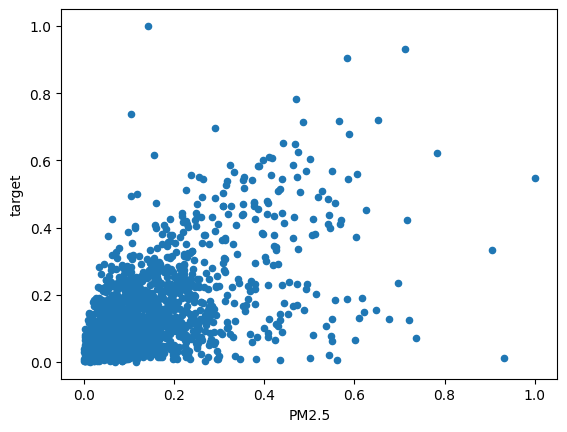

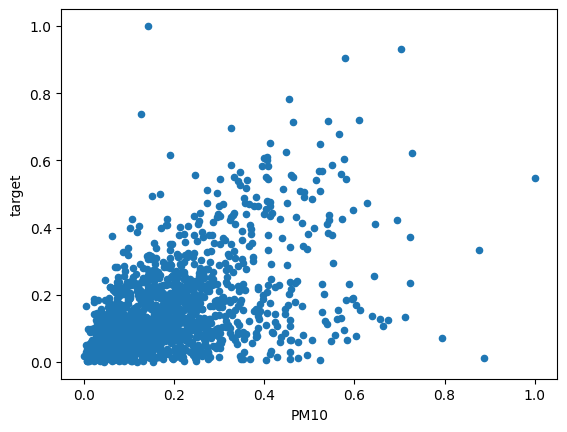

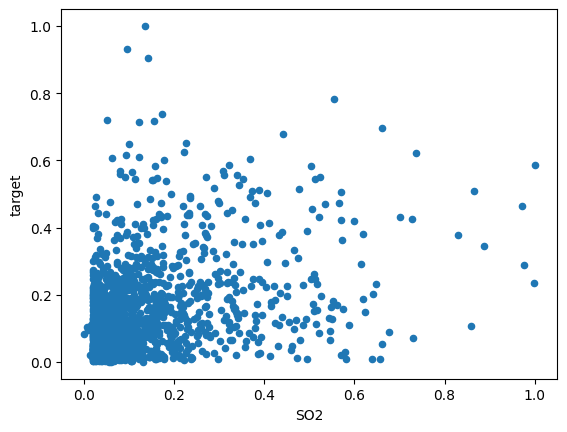

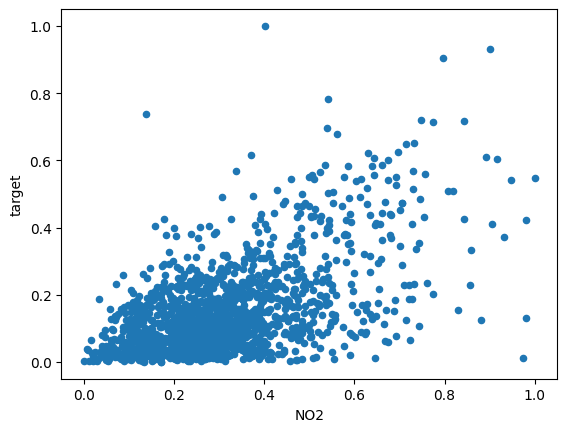

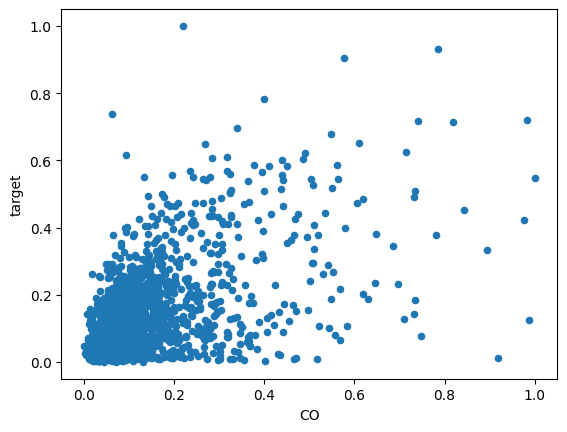

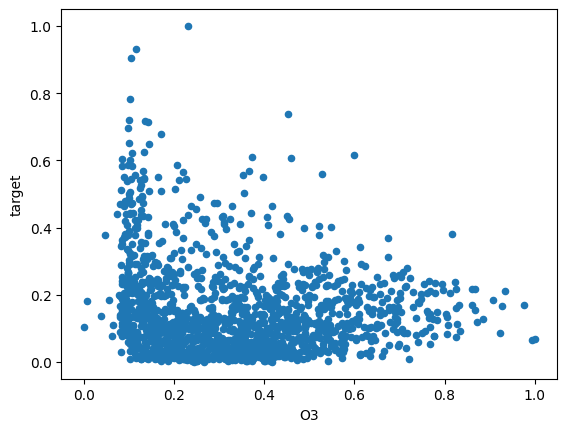

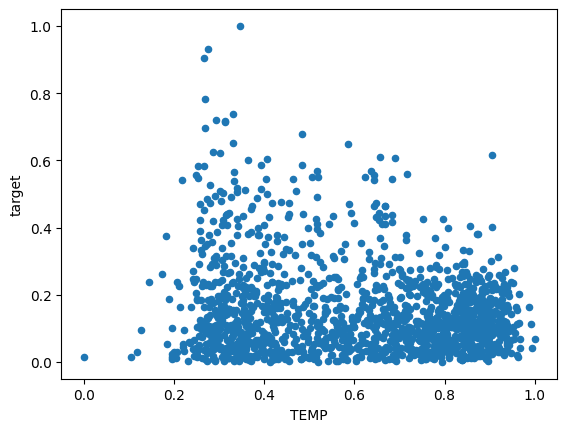

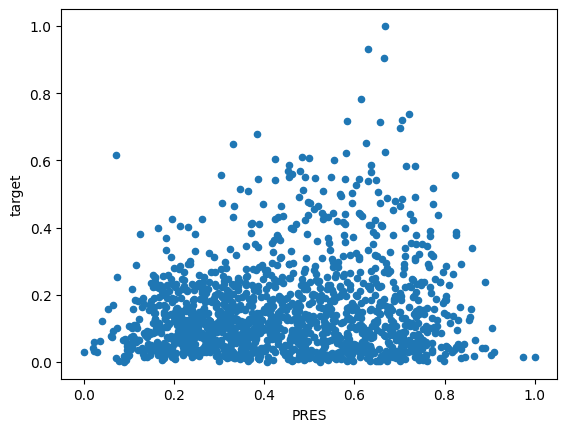

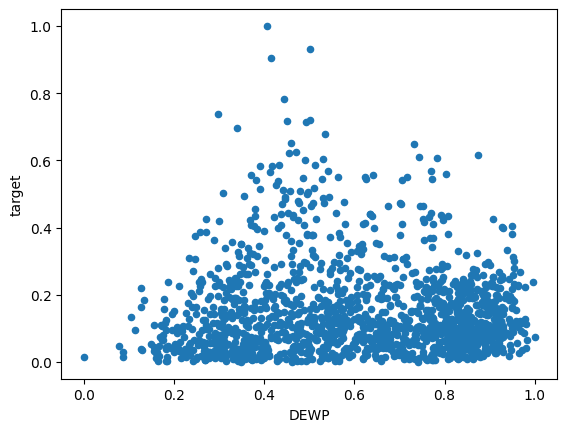

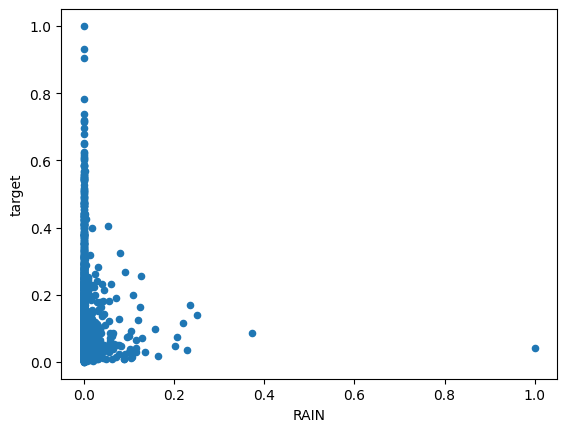

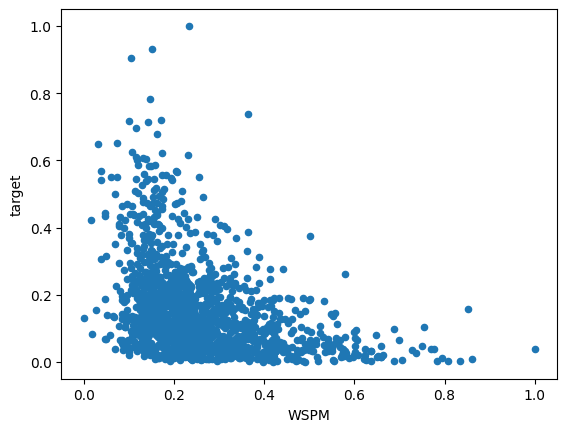

In [36]:
for feature in MODEL_INPUT_FEATURES:
    dataset_df[['target',feature]].plot(
        kind='scatter',
        y='target',
        x=feature)

In [37]:
from torch import Tensor
from numpy import concatenate, clip
from torch.utils.data import Dataset
from numpy.lib.stride_tricks import sliding_window_view

class FeatureForcastingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, pred_feature:str, past_window:int, future:int, future_window:int, model_features:list=MODEL_INPUT_FEATURES, split_date:str='2015-03-01 00:00:00', is_train:bool=True):  
        # self.pred_feature = pred_feature
        # self.model_features = model_features
        # self.past_window = past_window
        # self.future_window = future_window

        # split to train and test 
        df = df[df.index < split_date] if is_train else df[df.index >= split_date] 
        
        # # normalize
        # norm_feature_df = df[self.model_features] 
        # self.mean = norm_feature_df.mean()
        # self.std = norm_feature_df.std()
        # norm_feature_df = ( norm_feature_df - self.mean ) / self.std
        
        # # build sliding window for features
        # cols = [f"{feature}_{index}" for feature in self.model_features for index in range(self.past_window)]
        features = df[model_features].to_numpy()
        
        # # build 1-hot encoding for month 
        # month_col = [f"month_{index}" for index in range(1,13)]
        # month_df = clip(sliding_window_view(df[month_col], window_shape=dataset_window, axis=0)[:,:,:-future_window].sum(axis=2),None,1)
        
        # build targets
        target = df[['target']].to_numpy()

        # build datset
        # features = concatenate([features,month_df],axis=1)
        self.features = Tensor(features)
        self.targets = Tensor(target)
        # discard variables
        del df

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
datset = FeatureForcastingDataset(dataset_df,MODEL_INPUT_FEATURES[0],PAST_WINDOW,1, FUTURE_WINDOW,is_train=True)
datset[1]

(tensor([0.0502, 0.0638, 0.2769, 0.3577, 0.0899, 0.2187, 0.3331, 0.7434, 0.2807,
         0.0000, 0.2174]),
 tensor([0.1413]))

In [41]:
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from sklearn.metrics import r2_score
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError

class FeatureForecastingModel(pl.LightningModule):
    def __init__(self, model_features:list=MODEL_INPUT_FEATURES, past_window:int=1, future_window:int=1, hidden_layer_size:int=2048, hidden_layers:int=3):
        super(FeatureForecastingModel, self).__init__()
        
        # init model features
        self.past_window = past_window
        self.future_window = future_window
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size

        layer_list = []

        # building input layer
        layer_list.append(nn.Linear(in_features=(len(model_features)), out_features=self.hidden_layer_size))
        layer_list.append(nn.LeakyReLU(0.1))
        # building hidden layers
        for h_layer in range(self.hidden_layers):
            layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=self.hidden_layer_size))
            layer_list.append(nn.LeakyReLU(0.1))
        # building ouput layer
        layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=1))

        # build model
        self.layers = nn.Sequential(*layer_list)
        
        # metics
        self.r2_score = R2Score()
        self.mae = MeanAbsoluteError()
        self.rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # Flatten the input images
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.r2_score(y_hat, y)
        self.log('r2_score', self.r2_score, on_epoch=True)
        self.mae(y_hat, y)
        self.log('mae', self.mae, on_epoch=True)
        self.rmse(y_hat, y)
        self.log('rmse', self.rmse, on_epoch=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)


In [43]:
from torch.utils.data import DataLoader 
import torch 
torch.set_float32_matmul_precision('medium')

import mlflow

# Auto log all MLflow entities
mlflow.pytorch.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("AQL-MM")

# Build Bataset
train_dataset = FeatureForcastingDataset(dataset_df,feature, future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=True)
val_dataset = FeatureForcastingDataset(dataset_df,feature,future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

# build model
model = FeatureForecastingModel(past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=2048, hidden_layers=3)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu", 
    logger=False,
    enable_progress_bar=True,
    enable_checkpointing=False,
    devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
)

# log model into mlflow
with mlflow.start_run():
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.validate(model, val_loader)

2023/06/10 14:50:04 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/10 14:50:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 12.6 M
1 | r2_score | R2Score         

Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]                    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

2023/06/10 14:52:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/10 14:52:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.0963675007224083     │
│         r2_score          │    0.17827224731445312    │
│           rmse            │     0.130449116230011     │
│         val_loss          │   0.017016973346471786    │
└───────────────────────────┴───────────────────────────┘